In [1]:
import pandas as pd
import scipy
import scipy.spatial
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

In [2]:
np.random.seed(29042022)

# Prepare Datasets

In [3]:
n_datasets = 1

DATASETS = []
N = 50 
sigma_1 = 1
sigma_2 = 2
n_max = 20

# N=10
# n_max=20

for _ in range(n_datasets):
    df_1 = []
    df_2 = []

    for i in range(N):
        n = np.random.randint(2,n_max)
        X = np.random.normal(0,sigma_1,size=(n,2))
        df_1.append(X)

    for i in range(N):
        n = np.random.randint(2,n_max//2)
        X = np.random.normal(0,sigma_2,size=(n,2))
        df_2.append(X)

    df = df_1 + df_2
    
    DATASETS.append(df)

In [4]:
def create_list(df):
    lista = []

    for X in df:
        delta=scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(X, metric='euclidean')) 
        lista.append(delta)
        
    return lista 

In [5]:
def extract_max(lista):
    
    M = 0
    
    for m in lista:
        if np.max(m)>M:
            M = np.max(m)
    return M
    
def normalize(lista, const = None, return_const = False):
    
    if const is None:
        M = extract_max(lista)
    else:
        M = const
    
    lista_M = []
    
    for m in lista:
        lista_M.append(m/M)
    
    if return_const: 
        return lista_M, M
    else:
        return lista_M

In [6]:
MATRICES_LIST_tmp = []

for i,df in enumerate(DATASETS):
    print(i)
    M = create_list(df)
    MATRICES_LIST_tmp.append(M)

0


In [7]:
MATRICES_LIST = []

for dataset in MATRICES_LIST_tmp:
    MATRICES_LIST.append(normalize(dataset, const = None))

# Create dendrograms

In [8]:
import sys

sys.path.insert(0, './Trees')

from Utils_dendrograms_OPT import dendrolink, prune_dendro, prune_dendro_N
from top_TED_lineare_multiplicity import top_TED_lineare as TED
import matplotlib.pyplot as plt
from scipy.stats import beta


In [9]:
DENDROGRAMS_LIST = []
MAX_LEAVES = 30
RANGES = []

for i,df in enumerate(MATRICES_LIST):
    print(i)
    TREES = []
    max_ = 0
    for j,m in enumerate(df):
#         print(j,end='\r')
        
        T = dendrolink(m,'average',root=True, root_height = 1)
        T.make_mult(f=False)
        T.make_norms_mult()
        TREES.append(T)
        if T.f_uniq[-1]>max_:
            max_= T.f_uniq[-1]

    RANGES.append(max_)        
    DENDROGRAMS_LIST.append(TREES)

0
Non iniettiva:  31 31
Ora è iniettiva:  31 31


## Check

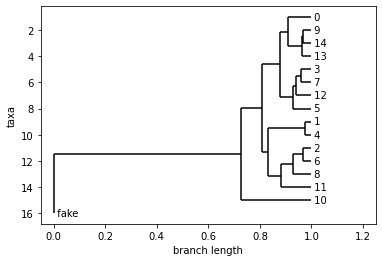

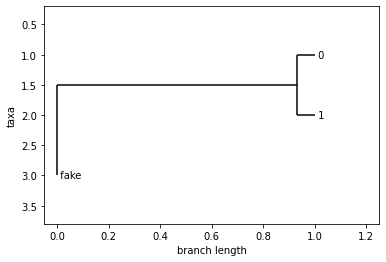

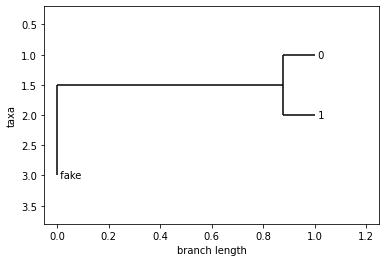

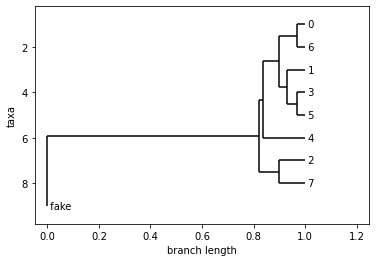

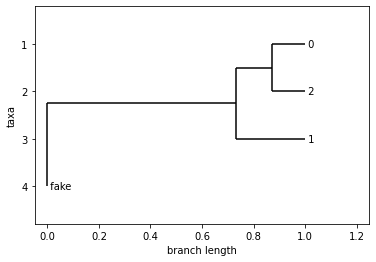

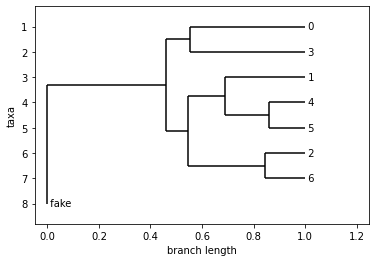

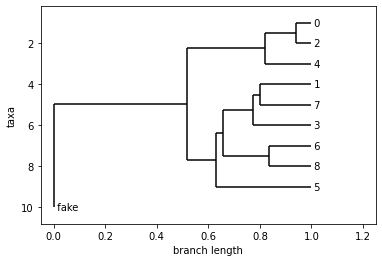

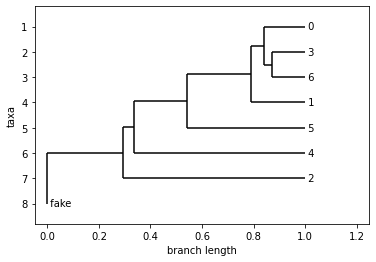

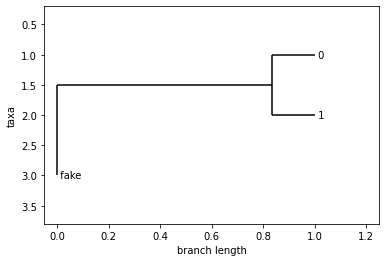

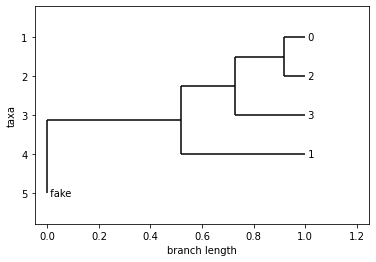

In [10]:
df_idx=0

for i in range(5):
    T = DENDROGRAMS_LIST[df_idx][i]
    T.plot_newick()
    
for i in range(5):
    T = DENDROGRAMS_LIST[df_idx][i+N]
    T.plot_newick()

# Auxiliary Functions

## Heights Distribution

In [11]:
def get_merging_times_distribution(TREES):
    
    times = []
    
    for T in TREES:
        times = times + list(T.f_uniq)
        
    return np.array(times)

## $d_P^\mu$

In [12]:
import multiprocessing as mp

def TED_aux(T,G):
    return TED(T, G, MP=True, root=False)
    
def TED_wrap(LIST):
    return TED(LIST[0], LIST[1], MP=False, root=False)

def TED_prune(T0, T1, min_leaves=30, min_samples = 20, plot=False):
    
    T_0 = []
    T_1 = []

    aux = np.linspace(0,1,min_samples)
    cnt = []
    tmp = 0
    
    thresholds = [aux[0]]

    for thresh in aux:
        T0_aux = prune_dendro(T0, thresh, mult=True)
        T0_aux.make_norms_mult()
        T1_aux = prune_dendro(T1, thresh, mult=True)
        T1_aux.make_norms_mult()
        
        if len(T0_aux.leaves)> min_leaves or len(T1_aux.leaves)> min_leaves:
            pass 
        elif len(T_0)==0 and len(T_1)==0:
            T_0.append(T0_aux)
            T_1.append(T1_aux)
#             thresholds.append(thresh)
            cnt.append(1)
        elif len(T0_aux.leaves) == len(T_0[-1].leaves) and \
            len(T1_aux.leaves) == len(T_1[-1].leaves):
            cnt[-1]+=1
            thresholds.append(thresh)
        else:
            T_0.append(T0_aux)
            T_1.append(T1_aux)
            thresholds.append(thresh)
            cnt.append(1)

    thresholds = np.array(thresholds)
    
    pool = mp.Pool(processes=7)
    d_tmp = pool.map(TED_wrap,([T_0[i],T_1[i]] for i in range(len(T_0))))
    pool.close()

    d = []
    idx = 0
    
    for c in cnt:
        for _ in range(c):
            d.append(d_tmp[idx])
        idx+=1
        
    d = np.array(d)
   
    a=2
    b=8
    w=beta.pdf(thresholds, a, b)
    
    f = d*w
       
    return sum(f[1:]*np.diff(thresholds))

### Verify Linearity of $d_E$

In [13]:
idx_dataset = 0
idx_m_0 = np.random.randint(0,2*N)
idx_m_1 = np.random.randint(0,2*N)

m_0 = MATRICES_LIST[idx_dataset][idx_m_0]
m_1 = MATRICES_LIST[idx_dataset][idx_m_1]

In [27]:
T_0 = dendrolink(m_0,'single',root=True)
T_0.make_mult(f=False)
T_0.make_norms_mult()

T_1 = dendrolink(m_1,'single',root=True)
T_1.make_mult(f=False)
T_1.make_norms_mult()

Non iniettiva:  33 33
Ora è iniettiva:  33 33


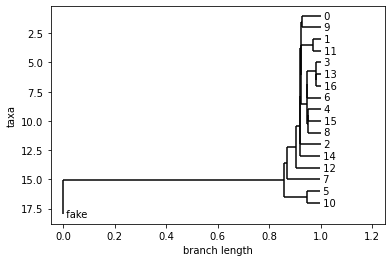

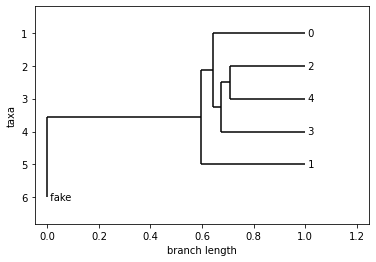

In [28]:
T_0.plot_newick()
T_1.plot_newick()

In [29]:
a = TED(T_0,T_1)
print(a)

2.0919575868804463


In [30]:
k=5

T_0 = dendrolink(k*m_0,'average',root=True)
T_0.make_mult(f=False)
T_0.make_norms_mult()

T_1 = dendrolink(k*m_1,'average',root=True)
T_1.make_mult(f=False)
T_1.make_norms_mult()

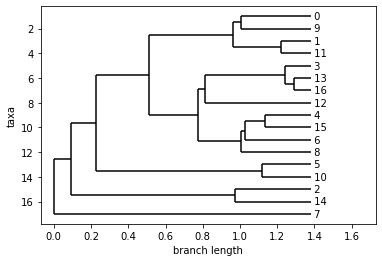

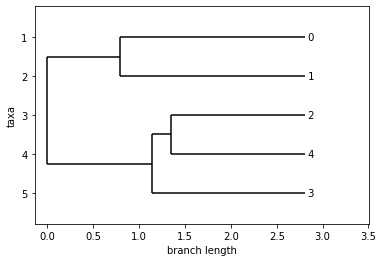

In [18]:
T_0.plot_newick()
T_1.plot_newick()

In [19]:
print(TED(T_0,T_1),a*k)

9.043046390130776 9.179648110796032


## Pairwise Distances

In [20]:
def pairwise_dist(TREES_list,dist):
    D=np.zeros((len(TREES_list),len(TREES_list)))
    
    for i in range(len(TREES_list)):
        print('Doing row : ',i, ' of ', len(TREES_list),'            ', end='\r')
        
        for j in range(i):
            TREES_list[i].make_mult(f=False)
            D[i,j] = dist(TREES_list[i],TREES_list[j])
    M=D+D.T
    
    return M

# Setting $\mu$

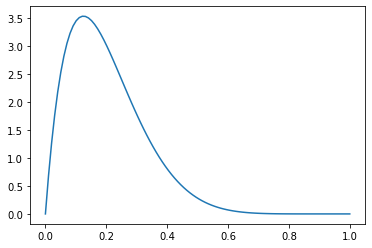

In [21]:
a=2
b=8
aux = np.linspace(0,1,100)

w=beta.pdf(aux, a, b)

plt.plot(aux,w)

In [22]:
DIST_LIST = []

for i,TREES in enumerate(DENDROGRAMS_LIST):
    print(i)
    dis = get_merging_times_distribution(TREES)
    DIST_LIST.append(dis)

0


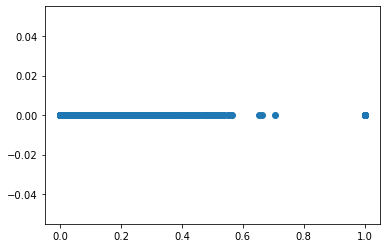

In [23]:
for d in DIST_LIST:
    plt.scatter(d,np.zeros_like(d))
    plt.show()

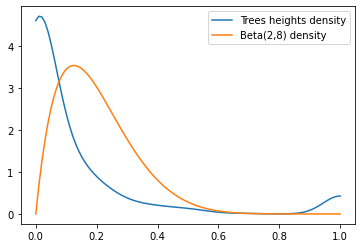

In [24]:
from scipy import stats

aux = np.linspace(0,1,100)
values = [d]
kernel = stats.gaussian_kde(values)
dens = kernel(aux)

plt.plot(aux,dens, label = 'Trees heights density')
plt.plot(aux,w,label = 'Beta('+str(a)+','+str(b)+') density')
plt.legend(loc="upper right")


# Compute Pairwise Distances

In [25]:
DISTANCES_LIST = []

## $d_E$

In [ ]:
for i,TREES in enumerate(DENDROGRAMS_LIST):
    print(i)
    M = pairwise_dist(TREES,TED_aux)
    DISTANCES_LIST.append(M)
    np.save('./Results/TED', M)

0


## $d_P^\mu$

In [ ]:
for i,TREES in enumerate(DENDROGRAMS_LIST):
    print(i)
    M = pairwise_dist(TREES,TED_prune)
    DISTANCES_LIST.append(M)
    np.save('./Results/pruning', M)

# Visual Inspection of Matrices

In [ ]:
DISTANCES_LIST = []

M=np.load("./Results/TED.npy")
DISTANCES_LIST.append(M)

M=np.load("./Results/pruning.npy")
DISTANCES_LIST.append(M)

In [ ]:
for m in DISTANCES_LIST:
    plt.imshow(m)
    plt.colorbar()
    plt.show()

# Clustering

## Clustering of $d^\mu_P$: average linkage 

In [ ]:
m = DISTANCES_LIST[1]
T = dendrolink(m,'average')

T.plot_newick()

In [ ]:
CLOUDS = []

for cut in [186,196]: 
    T_clus = T.sub_tree(cut)
    clus = [T_clus.name_vertices[l] for l in T_clus.leaves]

    cloud = []

    for idx_c in clus:
        c = DATASETS[idx_dataset][idx_c]
        cloud+=list(c)

    CLOUDS.append(np.array(cloud))   

## Clustering of $d^\mu_P$: ward linkage 

In [ ]:
m = DISTANCES_LIST[1]
T = dendrolink(m,'ward')

T.plot_newick()

In [ ]:
print(T.find_children(max(T.vertices)))

In [ ]:
CLOUDS = []

for cut in [194, 197]: 
    T_clus = T.sub_tree(cut)
    clus = [T_clus.name_vertices[l] for l in T_clus.leaves]

    cloud = []

    for idx_c in clus:
        c = DATASETS[idx_dataset][idx_c]
        cloud+=list(c)

    CLOUDS.append(np.array(cloud)) 

## Clustering of $d_E$

In [ ]:
m = DISTANCES_LIST[0]
T = dendrolink(m,'ward')

T.plot_newick()

In [ ]:
print(T.find_children(max(T.vertices)))

In [ ]:
CLOUDS_d_E = []

for cut in [196, 197]: 
    T_clus = T.sub_tree(cut)
    clus = [T_clus.name_vertices[l] for l in T_clus.leaves]

    cloud = []

    for idx_c in clus:
        c = DATASETS[idx_dataset][idx_c]
        cloud+=list(c)

    CLOUDS_d_E.append(np.array(cloud))

## Density estimation

We estimate the density of the point clouds generated by the clusters in one of the above cases.

In [ ]:
from scipy.stats import norm

aux = np.linspace(-10,10,1000)
pdf_norm_1 = norm.pdf(aux,loc=0,scale=sigma_1)
pdf_norm_2 = norm.pdf(aux,loc=0,scale=sigma_2)

for c in CLOUDS:
# for c in CLOUDS_d_E:

    values = [c[:,0]]
    kernel = stats.gaussian_kde(values)
    dens = kernel(aux)
    
    plt.plot(aux,dens, label='Estimated Density')
    plt.plot(aux,pdf_norm_1,label='Normal(0,1)')
    plt.plot(aux,pdf_norm_2,label='Normal(0,2)')
    plt.legend(loc="upper right")
    plt.show()
    
    values = [c[:,1]]
    kernel = stats.gaussian_kde(values)
    dens = kernel(aux)
    
    plt.plot(aux,dens, label='Estimated Density')
    plt.plot(aux,pdf_norm_1,label='Normal(0,1)')
    plt.plot(aux,pdf_norm_2,label='Normal(0,2)')
    plt.legend(loc="upper right")
    plt.show()